In [1]:
%load_ext watermark
%watermark -a Chan -d -v -p numpy,pandas,sklearn,konlpy,tensorflow,matplotlib,imblearn

Chan 2019-08-14 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
konlpy 0.5.1
tensorflow 1.13.1
matplotlib 3.1.0
imblearn 0.5.0


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
import pickle
from utils import morp_preprocessing

# Load datasets

In [28]:
datasets = pd.read_csv('../../data/train.csv', engine='python', encoding='utf-16')
datasets.head()

,Unnamed: 0,comment,url_id,label
0,0,ㅜㅜ,77,0
1,1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,17,0
2,2,헐,52,0
3,3,제시,75,0
4,4,이거인 듯,18,0


In [29]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Data columns (total 4 columns):
Unnamed: 0    42000 non-null int64
comment       42000 non-null object
url_id        42000 non-null int64
label         42000 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.3+ MB


In [44]:
len(datasets[datasets.label ==1])/ len(datasets) # 유해한 레이블의 데이터가 많이 부족함 데이터 편향ㅠㅠ 

0.0499047619047619

# 형태소분석

In [32]:
morp = Okt()

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [33]:
morped = [morp.morphs(_, norm=True, stem=True) for _ in tqdm(datasets.comment)]
morped[:5]

100%|███████████████████████████████████████████████████████████████████████████| 42000/42000 [01:28<00:00, 472.30it/s]


[['ㅜㅜ'], ['ㅋㅋㅋ'], ['헐다'], ['제시'], ['이', '거인', '듯']]

## Dictionary
최빈 형태소에 대한 단어사전 구성

In [34]:
vocab_size = 30000

pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
    word_counter = Counter()

    for sent in sentences:
        word_counter.update(sent)

    most_common = word_counter.most_common()
    print("고빈도 단어:")
    for k, v in most_common[:10]:
        print(k, ": ", v)

        vocab = {
        '<PAD>': pad_id,
        '<OOV>': oov_id
        }
    for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
        vocab[word] = i
        if len(vocab) >= vocab_size:
            break

    return vocab

word_index = make_vocab(morped)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
    print(i, word_inverted_index[i])

print("\n단어 사전 크기: ", len(word_index))

# # vocab save
# with open('./vocab/vocab_index.pickle', 'wb') as f:
#     pickle.dump(word_index, f, pickle.HIGHEST_PROTOCOL)
# with open('./vocab/vocab_inverted_index.pickle', 'wb') as f:
#     pickle.dump(word_inverted_index, f, pickle.HIGHEST_PROTOCOL)

고빈도 단어:
ㅋㅋㅋ :  7874
? :  3235
이 :  3011
하다 :  2327
! :  1151
ㅋㅋ :  1114
가 :  1020
오다 :  969
아 :  911
이다 :  789

단어 사전:
0 <PAD>
1 <OOV>
2 ㅋㅋㅋ
3 ?
4 이
5 하다
6 !
7 ㅋㅋ
8 가
9 오다

단어 사전 크기:  15600


In [35]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(tokens):
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)

    return indexes

print("원본: ", morped[0])
ids = text_to_index(morped[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ['ㅜㅜ']
문자 -> 숫자:  [282]
숫자 -> 문자:  ㅜㅜ


In [36]:
x_variable = [text_to_index(_) for _ in morped]

sentence_size = 10
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

In [37]:
def plot_loss(history):
    plt.figure(figsize=(6,5))
    val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.xlim([0,max(history.epoch)])

In [38]:
import warnings
warnings.filterwarnings(action='once')


# 데이터 클래스 불균형 문제 해결하자

In [39]:
X_train, X_test, y_train, y_test = train_test_split(x_padded, datasets.label)

In [116]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE

In [151]:
up_X, up_y = RandomOverSampler().fit_resample(X_train, y_train)

# 총 데이터 수 , 1 레이블 데이터 수
len(up_y), up_y.sum()

(59872, 29936)

In [152]:
model_up = keras.Sequential([
    keras.layers.Embedding(vocab_size, 10),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\numpy\lib\type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Train on 59872 samples, validate on 10500 samples
Epoch 1/5


20320/59872 [=========>....................] - ETA: 1:21:34 - loss: 0.0164 - recall_18: 1.00 - ETA: 16:38 - loss: 0.0710 - recall_18: 0.9875 - ETA: 9:30 - loss: 0.0818 - recall_18: 0.9826 - ETA: 6:43 - loss: 0.0619 - recall_18: 0.985 - ETA: 5:14 - loss: 0.0604 - recall_18: 0.987 - ETA: 4:19 - loss: 0.0588 - recall_18: 0.985 - ETA: 3:41 - loss: 0.0657 - recall_18: 0.982 - ETA: 3:14 - loss: 0.0676 - recall_18: 0.981 - ETA: 2:58 - loss: 0.0677 - recall_18: 0.981 - ETA: 2:47 - loss: 0.0681 - recall_18: 0.980 - ETA: 2:32 - loss: 0.0654 - recall_18: 0.980 - ETA: 2:20 - loss: 0.0690 - recall_18: 0.979 - ETA: 2:10 - loss: 0.0689 - recall_18: 0.980 - ETA: 2:02 - loss: 0.0668 - recall_18: 0.979 - ETA: 1:59 - loss: 0.0650 - recall_18: 0.980 - ETA: 1:52 - loss: 0.0629 - recall_18: 0.981 - ETA: 1:48 - loss: 0.0657 - recall_18: 0.980 - ETA: 1:42 - loss: 0.0637 - recall_18: 0.981 - ETA: 1:38 - loss: 0.0628 - recall_18: 0.981 - ETA: 1:35 - loss: 0.0617 - recall_18: 0.981 - ETA: 1:32 - loss: 0.0602 - r

41056/59872 [===================>..........] - ETA: 25s - loss: 0.0552 - recall_18: 0.98 - ETA: 25s - loss: 0.0554 - recall_18: 0.98 - ETA: 25s - loss: 0.0554 - recall_18: 0.98 - ETA: 25s - loss: 0.0551 - recall_18: 0.98 - ETA: 25s - loss: 0.0555 - recall_18: 0.98 - ETA: 24s - loss: 0.0556 - recall_18: 0.98 - ETA: 24s - loss: 0.0556 - recall_18: 0.98 - ETA: 24s - loss: 0.0559 - recall_18: 0.98 - ETA: 24s - loss: 0.0558 - recall_18: 0.98 - ETA: 24s - loss: 0.0560 - recall_18: 0.98 - ETA: 24s - loss: 0.0561 - recall_18: 0.98 - ETA: 24s - loss: 0.0560 - recall_18: 0.98 - ETA: 24s - loss: 0.0562 - recall_18: 0.98 - ETA: 24s - loss: 0.0564 - recall_18: 0.98 - ETA: 24s - loss: 0.0563 - recall_18: 0.98 - ETA: 23s - loss: 0.0566 - recall_18: 0.98 - ETA: 23s - loss: 0.0569 - recall_18: 0.98 - ETA: 23s - loss: 0.0570 - recall_18: 0.98 - ETA: 23s - loss: 0.0571 - recall_18: 0.98 - ETA: 23s - loss: 0.0571 - recall_18: 0.98 - ETA: 23s - loss: 0.0570 - recall_18: 0.98 - ETA: 23s - loss: 0.0571 - rec

59872/59872 [==============================] - ETA: 10s - loss: 0.0581 - recall_18: 0.98 - ETA: 10s - loss: 0.0581 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0582 - recall_18: 0.98 - ETA: 10s - loss: 0.0581 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0580 - recall_18: 0.98 - ETA: 10s - loss: 0.0579 - recall_18: 0.98 - ETA: 10s - loss: 0.0579 - recall_18: 0.98 - ETA: 10s - loss: 0.0579 - recall_18: 0.98 - ETA: 10s - loss: 0.0578 - recall_18: 0.98 - ETA: 9s - loss: 0.0577 - recall_18: 0.9819 - ETA: 9s - loss: 0.0577 - recall_18: 0.981 - ETA: 9s - loss: 0.0579 - recall_18: 0.981 - ETA: 9s - loss: 0.0580 - recall_18: 0.981 - ETA: 9s - loss: 0.0579 - recall_18: 0.981 - ETA: 9s - loss: 0.0580 - rec

21024/59872 [=========>....................] - ETA: 35s - loss: 0.0072 - recall_18: 1.00 - ETA: 29s - loss: 0.0434 - recall_18: 0.98 - ETA: 27s - loss: 0.0341 - recall_18: 0.98 - ETA: 27s - loss: 0.0397 - recall_18: 0.98 - ETA: 26s - loss: 0.0540 - recall_18: 0.97 - ETA: 27s - loss: 0.0525 - recall_18: 0.97 - ETA: 27s - loss: 0.0487 - recall_18: 0.98 - ETA: 26s - loss: 0.0455 - recall_18: 0.98 - ETA: 26s - loss: 0.0527 - recall_18: 0.98 - ETA: 27s - loss: 0.0564 - recall_18: 0.98 - ETA: 27s - loss: 0.0556 - recall_18: 0.98 - ETA: 27s - loss: 0.0560 - recall_18: 0.98 - ETA: 27s - loss: 0.0615 - recall_18: 0.98 - ETA: 27s - loss: 0.0684 - recall_18: 0.98 - ETA: 27s - loss: 0.0669 - recall_18: 0.98 - ETA: 27s - loss: 0.0647 - recall_18: 0.98 - ETA: 27s - loss: 0.0622 - recall_18: 0.98 - ETA: 27s - loss: 0.0644 - recall_18: 0.98 - ETA: 27s - loss: 0.0626 - recall_18: 0.98 - ETA: 27s - loss: 0.0618 - recall_18: 0.98 - ETA: 27s - loss: 0.0593 - recall_18: 0.98 - ETA: 28s - loss: 0.0576 - rec

42112/59872 [====================>.........] - ETA: 19s - loss: 0.0475 - recall_18: 0.98 - ETA: 19s - loss: 0.0477 - recall_18: 0.98 - ETA: 19s - loss: 0.0475 - recall_18: 0.98 - ETA: 19s - loss: 0.0475 - recall_18: 0.98 - ETA: 19s - loss: 0.0477 - recall_18: 0.98 - ETA: 19s - loss: 0.0475 - recall_18: 0.98 - ETA: 19s - loss: 0.0479 - recall_18: 0.98 - ETA: 19s - loss: 0.0478 - recall_18: 0.98 - ETA: 19s - loss: 0.0477 - recall_18: 0.98 - ETA: 19s - loss: 0.0478 - recall_18: 0.98 - ETA: 19s - loss: 0.0478 - recall_18: 0.98 - ETA: 19s - loss: 0.0476 - recall_18: 0.98 - ETA: 19s - loss: 0.0477 - recall_18: 0.98 - ETA: 19s - loss: 0.0479 - recall_18: 0.98 - ETA: 19s - loss: 0.0479 - recall_18: 0.98 - ETA: 19s - loss: 0.0479 - recall_18: 0.98 - ETA: 19s - loss: 0.0479 - recall_18: 0.98 - ETA: 18s - loss: 0.0478 - recall_18: 0.98 - ETA: 18s - loss: 0.0478 - recall_18: 0.98 - ETA: 18s - loss: 0.0479 - recall_18: 0.98 - ETA: 18s - loss: 0.0479 - recall_18: 0.98 - ETA: 18s - loss: 0.0479 - rec

59872/59872 [==============================] - ETA: 9s - loss: 0.0468 - recall_18: 0.985 - ETA: 9s - loss: 0.0468 - recall_18: 0.985 - ETA: 8s - loss: 0.0467 - recall_18: 0.985 - ETA: 8s - loss: 0.0468 - recall_18: 0.985 - ETA: 8s - loss: 0.0469 - recall_18: 0.985 - ETA: 8s - loss: 0.0469 - recall_18: 0.985 - ETA: 8s - loss: 0.0469 - recall_18: 0.985 - ETA: 8s - loss: 0.0469 - recall_18: 0.985 - ETA: 8s - loss: 0.0469 - recall_18: 0.985 - ETA: 8s - loss: 0.0470 - recall_18: 0.985 - ETA: 8s - loss: 0.0470 - recall_18: 0.985 - ETA: 8s - loss: 0.0469 - recall_18: 0.985 - ETA: 8s - loss: 0.0468 - recall_18: 0.985 - ETA: 8s - loss: 0.0468 - recall_18: 0.985 - ETA: 8s - loss: 0.0467 - recall_18: 0.985 - ETA: 8s - loss: 0.0467 - recall_18: 0.985 - ETA: 8s - loss: 0.0467 - recall_18: 0.985 - ETA: 8s - loss: 0.0468 - recall_18: 0.985 - ETA: 8s - loss: 0.0467 - recall_18: 0.985 - ETA: 7s - loss: 0.0466 - recall_18: 0.985 - ETA: 7s - loss: 0.0466 - recall_18: 0.985 - ETA: 7s - loss: 0.0467 - reca

20736/59872 [=========>....................] - ETA: 41s - loss: 0.0166 - recall_18: 1.00 - ETA: 30s - loss: 0.0279 - recall_18: 0.99 - ETA: 30s - loss: 0.0338 - recall_18: 0.98 - ETA: 30s - loss: 0.0327 - recall_18: 0.98 - ETA: 29s - loss: 0.0286 - recall_18: 0.99 - ETA: 29s - loss: 0.0382 - recall_18: 0.98 - ETA: 29s - loss: 0.0354 - recall_18: 0.98 - ETA: 28s - loss: 0.0325 - recall_18: 0.98 - ETA: 28s - loss: 0.0340 - recall_18: 0.98 - ETA: 28s - loss: 0.0337 - recall_18: 0.98 - ETA: 28s - loss: 0.0370 - recall_18: 0.98 - ETA: 28s - loss: 0.0356 - recall_18: 0.98 - ETA: 28s - loss: 0.0344 - recall_18: 0.98 - ETA: 28s - loss: 0.0380 - recall_18: 0.98 - ETA: 28s - loss: 0.0379 - recall_18: 0.98 - ETA: 28s - loss: 0.0405 - recall_18: 0.98 - ETA: 29s - loss: 0.0404 - recall_18: 0.98 - ETA: 29s - loss: 0.0408 - recall_18: 0.98 - ETA: 30s - loss: 0.0402 - recall_18: 0.98 - ETA: 29s - loss: 0.0399 - recall_18: 0.98 - ETA: 29s - loss: 0.0401 - recall_18: 0.98 - ETA: 29s - loss: 0.0395 - rec

40960/59872 [===================>..........] - ETA: 20s - loss: 0.0426 - recall_18: 0.98 - ETA: 20s - loss: 0.0425 - recall_18: 0.98 - ETA: 20s - loss: 0.0423 - recall_18: 0.98 - ETA: 20s - loss: 0.0422 - recall_18: 0.98 - ETA: 20s - loss: 0.0421 - recall_18: 0.98 - ETA: 19s - loss: 0.0421 - recall_18: 0.98 - ETA: 19s - loss: 0.0419 - recall_18: 0.98 - ETA: 19s - loss: 0.0417 - recall_18: 0.98 - ETA: 19s - loss: 0.0416 - recall_18: 0.98 - ETA: 19s - loss: 0.0417 - recall_18: 0.98 - ETA: 19s - loss: 0.0418 - recall_18: 0.98 - ETA: 19s - loss: 0.0418 - recall_18: 0.98 - ETA: 19s - loss: 0.0418 - recall_18: 0.98 - ETA: 19s - loss: 0.0419 - recall_18: 0.98 - ETA: 19s - loss: 0.0419 - recall_18: 0.98 - ETA: 19s - loss: 0.0420 - recall_18: 0.98 - ETA: 19s - loss: 0.0420 - recall_18: 0.98 - ETA: 19s - loss: 0.0423 - recall_18: 0.98 - ETA: 19s - loss: 0.0421 - recall_18: 0.98 - ETA: 19s - loss: 0.0424 - recall_18: 0.98 - ETA: 19s - loss: 0.0423 - recall_18: 0.98 - ETA: 19s - loss: 0.0423 - rec

59872/59872 [==============================] - ETA: 9s - loss: 0.0445 - recall_18: 0.9860 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0445 - recall_18: 0.986 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0445 - recall_18: 0.985 - ETA: 9s - loss: 0.0447 - recall_18: 0.985 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0446 - recall_18: 0.985 - ETA: 9s - loss: 0.0445 - recall_18: 0.985 - ETA: 9s - loss: 0.0445 - recall_18: 0.986 - ETA: 9s - loss: 0.0445 - recall_18: 0.986 - ETA: 9s - loss: 0.0445 - recall_18: 0.985 - ETA: 9s - loss: 0.0445 - recall_18: 0.986 - ETA: 9s - loss: 0.0444 - recall_18: 0.986 - ETA: 9s - loss: 0.0444 - recall_18: 0.986 - ETA: 9s - loss: 0.0444 - recall_18: 0.986 - ETA: 9s - loss: 0.0445 - recall_18: 0.986 - ETA: 9s - loss: 0.0444 - rec

18944/59872 [========>.....................] - ETA: 52s - loss: 0.0042 - recall_18: 1.00 - ETA: 32s - loss: 0.0878 - recall_18: 0.96 - ETA: 32s - loss: 0.0706 - recall_18: 0.97 - ETA: 32s - loss: 0.0615 - recall_18: 0.97 - ETA: 32s - loss: 0.0565 - recall_18: 0.97 - ETA: 34s - loss: 0.0497 - recall_18: 0.97 - ETA: 35s - loss: 0.0531 - recall_18: 0.97 - ETA: 35s - loss: 0.0521 - recall_18: 0.97 - ETA: 36s - loss: 0.0477 - recall_18: 0.97 - ETA: 36s - loss: 0.0491 - recall_18: 0.97 - ETA: 36s - loss: 0.0469 - recall_18: 0.97 - ETA: 37s - loss: 0.0446 - recall_18: 0.98 - ETA: 37s - loss: 0.0421 - recall_18: 0.98 - ETA: 37s - loss: 0.0409 - recall_18: 0.98 - ETA: 39s - loss: 0.0436 - recall_18: 0.98 - ETA: 39s - loss: 0.0431 - recall_18: 0.98 - ETA: 38s - loss: 0.0408 - recall_18: 0.98 - ETA: 39s - loss: 0.0410 - recall_18: 0.98 - ETA: 39s - loss: 0.0430 - recall_18: 0.98 - ETA: 39s - loss: 0.0413 - recall_18: 0.98 - ETA: 39s - loss: 0.0414 - recall_18: 0.98 - ETA: 39s - loss: 0.0425 - rec

41984/59872 [====================>.........] - ETA: 23s - loss: 0.0415 - recall_18: 0.98 - ETA: 23s - loss: 0.0414 - recall_18: 0.98 - ETA: 23s - loss: 0.0417 - recall_18: 0.98 - ETA: 23s - loss: 0.0415 - recall_18: 0.98 - ETA: 23s - loss: 0.0415 - recall_18: 0.98 - ETA: 23s - loss: 0.0414 - recall_18: 0.98 - ETA: 23s - loss: 0.0415 - recall_18: 0.98 - ETA: 23s - loss: 0.0414 - recall_18: 0.98 - ETA: 23s - loss: 0.0413 - recall_18: 0.98 - ETA: 22s - loss: 0.0412 - recall_18: 0.98 - ETA: 22s - loss: 0.0411 - recall_18: 0.98 - ETA: 22s - loss: 0.0411 - recall_18: 0.98 - ETA: 22s - loss: 0.0411 - recall_18: 0.98 - ETA: 22s - loss: 0.0413 - recall_18: 0.98 - ETA: 22s - loss: 0.0411 - recall_18: 0.98 - ETA: 22s - loss: 0.0410 - recall_18: 0.98 - ETA: 22s - loss: 0.0408 - recall_18: 0.98 - ETA: 22s - loss: 0.0407 - recall_18: 0.98 - ETA: 22s - loss: 0.0407 - recall_18: 0.98 - ETA: 22s - loss: 0.0411 - recall_18: 0.98 - ETA: 21s - loss: 0.0409 - recall_18: 0.98 - ETA: 21s - loss: 0.0408 - rec

59872/59872 [==============================] - ETA: 9s - loss: 0.0423 - recall_18: 0.986 - ETA: 9s - loss: 0.0423 - recall_18: 0.987 - ETA: 9s - loss: 0.0423 - recall_18: 0.986 - ETA: 8s - loss: 0.0424 - recall_18: 0.986 - ETA: 8s - loss: 0.0425 - recall_18: 0.986 - ETA: 8s - loss: 0.0426 - recall_18: 0.986 - ETA: 8s - loss: 0.0425 - recall_18: 0.986 - ETA: 8s - loss: 0.0425 - recall_18: 0.986 - ETA: 8s - loss: 0.0426 - recall_18: 0.986 - ETA: 8s - loss: 0.0425 - recall_18: 0.986 - ETA: 8s - loss: 0.0425 - recall_18: 0.986 - ETA: 8s - loss: 0.0426 - recall_18: 0.986 - ETA: 8s - loss: 0.0427 - recall_18: 0.986 - ETA: 8s - loss: 0.0427 - recall_18: 0.986 - ETA: 8s - loss: 0.0426 - recall_18: 0.986 - ETA: 8s - loss: 0.0427 - recall_18: 0.986 - ETA: 8s - loss: 0.0429 - recall_18: 0.986 - ETA: 8s - loss: 0.0428 - recall_18: 0.986 - ETA: 7s - loss: 0.0428 - recall_18: 0.986 - ETA: 7s - loss: 0.0428 - recall_18: 0.986 - ETA: 7s - loss: 0.0427 - recall_18: 0.986 - ETA: 7s - loss: 0.0428 - reca

23264/59872 [==========>...................] - ETA: 42s - loss: 0.0582 - recall_18: 0.96 - ETA: 28s - loss: 0.0435 - recall_18: 0.97 - ETA: 27s - loss: 0.0416 - recall_18: 0.98 - ETA: 27s - loss: 0.0387 - recall_18: 0.98 - ETA: 28s - loss: 0.0451 - recall_18: 0.98 - ETA: 29s - loss: 0.0463 - recall_18: 0.98 - ETA: 28s - loss: 0.0427 - recall_18: 0.98 - ETA: 28s - loss: 0.0427 - recall_18: 0.98 - ETA: 28s - loss: 0.0394 - recall_18: 0.98 - ETA: 27s - loss: 0.0390 - recall_18: 0.98 - ETA: 27s - loss: 0.0371 - recall_18: 0.98 - ETA: 27s - loss: 0.0368 - recall_18: 0.98 - ETA: 27s - loss: 0.0356 - recall_18: 0.98 - ETA: 27s - loss: 0.0338 - recall_18: 0.98 - ETA: 27s - loss: 0.0325 - recall_18: 0.98 - ETA: 27s - loss: 0.0328 - recall_18: 0.98 - ETA: 27s - loss: 0.0318 - recall_18: 0.98 - ETA: 27s - loss: 0.0348 - recall_18: 0.98 - ETA: 27s - loss: 0.0336 - recall_18: 0.98 - ETA: 27s - loss: 0.0365 - recall_18: 0.98 - ETA: 27s - loss: 0.0364 - recall_18: 0.98 - ETA: 27s - loss: 0.0389 - rec

43520/59872 [====================>.........] - ETA: 16s - loss: 0.0374 - recall_18: 0.98 - ETA: 16s - loss: 0.0374 - recall_18: 0.98 - ETA: 16s - loss: 0.0377 - recall_18: 0.98 - ETA: 16s - loss: 0.0376 - recall_18: 0.98 - ETA: 16s - loss: 0.0375 - recall_18: 0.98 - ETA: 16s - loss: 0.0374 - recall_18: 0.98 - ETA: 16s - loss: 0.0374 - recall_18: 0.98 - ETA: 16s - loss: 0.0373 - recall_18: 0.98 - ETA: 16s - loss: 0.0375 - recall_18: 0.98 - ETA: 16s - loss: 0.0375 - recall_18: 0.98 - ETA: 16s - loss: 0.0374 - recall_18: 0.98 - ETA: 16s - loss: 0.0381 - recall_18: 0.98 - ETA: 15s - loss: 0.0383 - recall_18: 0.98 - ETA: 15s - loss: 0.0382 - recall_18: 0.98 - ETA: 15s - loss: 0.0381 - recall_18: 0.98 - ETA: 15s - loss: 0.0380 - recall_18: 0.98 - ETA: 15s - loss: 0.0381 - recall_18: 0.98 - ETA: 15s - loss: 0.0382 - recall_18: 0.98 - ETA: 15s - loss: 0.0382 - recall_18: 0.98 - ETA: 15s - loss: 0.0380 - recall_18: 0.98 - ETA: 15s - loss: 0.0381 - recall_18: 0.98 - ETA: 15s - loss: 0.0380 - rec

10500/10500 [==============================] - ETA: 1s - loss: 0.5221 - recall_18: 0.968 - ETA: 1s - loss: 0.8983 - recall_18: 0.917 - ETA: 1s - loss: 0.6966 - recall_18: 0.925 - ETA: 1s - loss: 0.6369 - recall_18: 0.929 - ETA: 1s - loss: 0.6423 - recall_18: 0.925 - ETA: 1s - loss: 0.6342 - recall_18: 0.926 - ETA: 1s - loss: 0.6171 - recall_18: 0.924 - ETA: 1s - loss: 0.5895 - recall_18: 0.925 - ETA: 1s - loss: 0.5935 - recall_18: 0.923 - ETA: 1s - loss: 0.5946 - recall_18: 0.923 - ETA: 1s - loss: 0.5659 - recall_18: 0.926 - ETA: 0s - loss: 0.5680 - recall_18: 0.926 - ETA: 0s - loss: 0.5693 - recall_18: 0.927 - ETA: 0s - loss: 0.5630 - recall_18: 0.928 - ETA: 0s - loss: 0.5524 - recall_18: 0.928 - ETA: 0s - loss: 0.5491 - recall_18: 0.928 - ETA: 0s - loss: 0.5404 - recall_18: 0.929 - ETA: 0s - loss: 0.5340 - recall_18: 0.930 - ETA: 0s - loss: 0.5288 - recall_18: 0.930 - ETA: 0s - loss: 0.5308 - recall_18: 0.929 - ETA: 0s - loss: 0.5314 - recall_18: 0.930 - ETA: 0s - loss: 0.5253 - reca

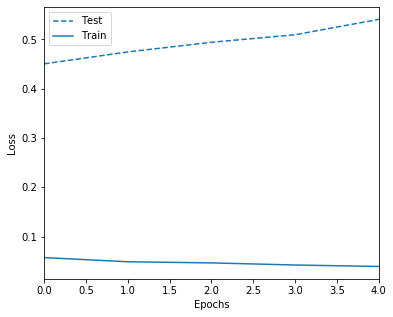

In [154]:
model_up.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_up.fit(up_X,
          pd.get_dummies(up_y),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
test_loss, test_acc = model_up.evaluate(X_test, pd.get_dummies(y_test))
print('Test accuracy:', test_acc)

In [155]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, X_test))
result['predict'] = model_up.predict_proba(X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)
result['label'] = y_test

전체채팅수10500, 유해채팅수625


### Recall

In [156]:
from sklearn.metrics import recall_score, accuracy_score, f1_score

In [159]:
recall_score(y_test, model_up.predict_classes(X_test)),\
accuracy_score(y_test, model_up.predict_classes(X_test)),\
f1_score(y_test, model_up.predict_classes(X_test))

(0.40225563909774437, 0.9306666666666666, 0.3702422145328719)

In [158]:
model_up.save('../model/cnn_oversample.h5')

## Downsampling

In [123]:
down_X, down_y = RandomUnderSampler().fit_resample(x_padded, datasets.label)

# 총 데이터 수 , 1 레이블 데이터 수
len(down_y), down_y.sum()

(4192, 2096)

In [139]:
model_down = keras.Sequential([
    keras.layers.Embedding(vocab_size, 10),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu,),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

Train on 4192 samples, validate on 10500 samples
Epoch 1/5
4192/4192 [==============================] - ETA: 4:34 - loss: 0.6969 - recall_15: 0.687 - ETA: 1:08 - loss: 0.6944 - recall_15: 0.718 - ETA: 34s - loss: 0.6943 - recall_15: 0.691 - ETA: 24s - loss: 0.6937 - recall_15: 0.65 - ETA: 18s - loss: 0.6936 - recall_15: 0.63 - ETA: 14s - loss: 0.6928 - recall_15: 0.61 - ETA: 11s - loss: 0.6931 - recall_15: 0.59 - ETA: 10s - loss: 0.6933 - recall_15: 0.58 - ETA: 9s - loss: 0.6931 - recall_15: 0.5862 - ETA: 8s - loss: 0.6929 - recall_15: 0.574 - ETA: 7s - loss: 0.6929 - recall_15: 0.561 - ETA: 6s - loss: 0.6930 - recall_15: 0.552 - ETA: 5s - loss: 0.6928 - recall_15: 0.549 - ETA: 5s - loss: 0.6929 - recall_15: 0.546 - ETA: 4s - loss: 0.6929 - recall_15: 0.542 - ETA: 4s - loss: 0.6929 - recall_15: 0.536 - ETA: 3s - loss: 0.6929 - recall_15: 0.528 - ETA: 3s - loss: 0.6928 - recall_15: 0.522 - ETA: 3s - loss: 0.6929 - recall_15: 0.515 - ETA: 2s - loss: 0.6927 - recall_15: 0.511 - ETA: 2s - 

10500/10500 [==============================] - ETA: 0s - loss: 0.9132 - recall_15: 0.750 - ETA: 0s - loss: 0.9630 - recall_15: 0.750 - ETA: 1s - loss: 0.8606 - recall_15: 0.769 - ETA: 1s - loss: 0.8582 - recall_15: 0.772 - ETA: 1s - loss: 0.8272 - recall_15: 0.776 - ETA: 1s - loss: 0.8493 - recall_15: 0.768 - ETA: 0s - loss: 0.8444 - recall_15: 0.768 - ETA: 0s - loss: 0.8592 - recall_15: 0.761 - ETA: 0s - loss: 0.8475 - recall_15: 0.763 - ETA: 0s - loss: 0.8533 - recall_15: 0.763 - ETA: 0s - loss: 0.8553 - recall_15: 0.761 - ETA: 0s - loss: 0.8609 - recall_15: 0.760 - ETA: 0s - loss: 0.8575 - recall_15: 0.761 - ETA: 0s - loss: 0.8594 - recall_15: 0.762 - ETA: 0s - loss: 0.8503 - recall_15: 0.764 - ETA: 0s - loss: 0.8545 - recall_15: 0.763 - ETA: 0s - loss: 0.8541 - recall_15: 0.761 - ETA: 0s - loss: 0.8517 - recall_15: 0.762 - ETA: 0s - loss: 0.8559 - recall_15: 0.762 - ETA: 0s - loss: 0.8595 - recall_15: 0.761 - ETA: 0s - loss: 0.8556 - recall_15: 0.760 - ETA: 0s - loss: 0.8605 - reca

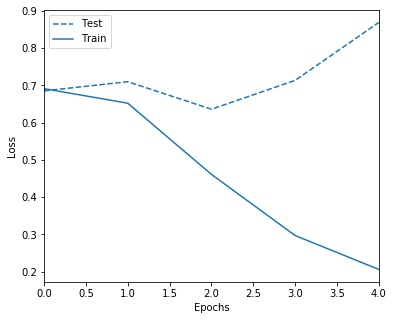

In [140]:
model_down.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_down.fit(down_X,
          pd.get_dummies(down_y),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
test_loss, test_acc = model_down.evaluate(X_test, pd.get_dummies(y_test))
print('Test Recall:', test_acc)

In [141]:
#recall
recall_score(y_test, model_down.predict_classes(X_test)), \
accuracy_score(y_test, model_down.predict_classes(X_test)),\
f1_score(y_test, model_down.predict_classes(X_test))

(0.9924812030075187, 0.7557142857142857, 0.29163214581607294)

In [143]:
result = pd.DataFrame(np.apply_along_axis(index_to_text, 1, X_test))
result['predict'] = model_down.predict_proba(X_test)[:,1] # 유해하다고 판별할 확률
print('전체채팅수{}, 유해채팅수{}'.format(len(result),len(result[result.predict>0.5])))
result[result.predict>0.5].head(10)
result['label'] = y_test

전체채팅수10500, 유해채팅수3095


## 모델 체크포인트 저장

In [142]:
model_down.save('../model/cnn_undersample.h5')

# TODO
- 형태소별 Tokenize 말고 한글 자모별 Tokenize 하여 실험해보기
- CNN layer / Parameter 변경시켜보기
- 예측 결과 검정하기
    - Attention 이용